### Trying different classifiers on data of KdV patients and ID controls
Overview of this notebook:

First the deepface representations of the cropped images are read in from an Excel file. The data is then plotted by using either t-sne or PCA for dimension reduction. It is clear that there aren't two clear clusters.

In the rest of the notebook the following classifiers are tested: k-NN, SVM, Random Forest, Gradient Boosting, AdaBoost, Gaussian Naive Bayes. In the end also an ensemble of all these methods or some of them is tried. None outperforming the Gradient Boosting classifier. 

To normalize the data either Normalizer (unit form) or StandardScaler (z = (x - mean)/std) is used, without any specific difference in performance yet.  

In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import itertools
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date

In [2]:
def read_dlib_rep(kdv_csv, ID_csv):
    data = []
    labels = []
    no_rep = []
    
    # get the representations from Excel files kdv
    with open (kdv_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for i, row in enumerate(reader):
            rep = list(map(float, row[1:]))
#             if all(v == 0 for v in rep):
#                 no_rep.append(i)
#             else:
            data.append(rep)
            labels.append(1)

    # get the representations from Excel files ID control
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for i, row in enumerate(reader):
#             if i not in no_rep: 
#                 rep = list(map(float, row[1:]))
            data.append(rep)
            labels.append(0)

    #print("All image representations are read in.")
    
    return np.array(data), np.array(labels)

In [3]:
def read_deepface_rep(kdv_csv, ID_csv):
    data = []
    labels = []

    # get the representations from Excel files kdv
    with open (kdv_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            rep = list(map(float, row[1:]))
            data.append(rep)
            labels.append(1)

    # get the representations from Excel files ID control
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            rep = list(map(float, row[1:]))
            data.append(rep)
            labels.append(0)

    #print("All image representations are read in.")
    
    return np.array(data), np.array(labels)

In [4]:
def plot_pca_tsne(data, labels, lowest_age = -1, highest_age = -1):
    plt.figure(figsize=(12,6))
    plt.plot([1,2])

    # visualize data in tnse (men/women)
    X_embedded_tsne = TSNE(n_components=2, init='pca').fit_transform(data)

    plt.subplot(121)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_tsne[j, 0] for j  in range(len(X_embedded_tsne[:,0])) if labels[j] == u]
        yi = [X_embedded_tsne[j, 1] for j  in range(len(X_embedded_tsne[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("t-sne for age range {}-{}".format(lowest_age, highest_age))

    # visualize data in pca (men/women)
    X_embedded_pca = PCA(n_components=2).fit_transform(data)

    plt.subplot(122)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_pca[j, 0] for j  in range(len(X_embedded_pca[:,0])) if labels[j] == u]
        yi = [X_embedded_pca[j, 1] for j  in range(len(X_embedded_pca[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("pca for age range{}-{}".format(lowest_age, highest_age))

    plt.show()

In [5]:
def plot_roc_curve(y_true, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(1, figsize=(12,6))
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [6]:
def calculate_metrics_loo(model, data, labels):
    all_y = []
    all_probs = []
    all_preds = []
    loo = LeaveOneOut()
    
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))
        
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn) 
    
    return aroc, spec, sens 

### Method 1: k-NN

In [7]:
def knn_classifier(data, labels):
    k_values = [3,4,5,6,7,8,9,10,11,12,13,14,15]
    best_aroc = 0
    best_k = 0

    for k in tqdm(k_values):
        for normalize in [0, 1, 2]:
            
            model = KNeighborsClassifier(n_neighbors=k, weights='distance')
            aroc, spec, sens = calculate_metrics_loo(model, data, labels)
           
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, normalize 
                best_k = k
                
    return best_k, best_norm, best_aroc, best_spec, best_sens

### Method 2: SVM

In [8]:
def svm_classifier(data, labels):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_aroc = 0
    best_kernel = None

    for k in tqdm(kernels):
        for normalize in [0, 1, 2]:
            
            model = SVC(kernel=k, probability=True)
            aroc, spec, sens = calculate_metrics_loo(model, data, labels)
           
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, normalize 
                best_kernel = k
                
    return best_kernel, best_norm, best_aroc, best_spec, best_sens

### Method 3: Random Forest

### Method 4: Gradient Boosting classifier

In [10]:
def gr_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20, 40, 60, 80, 100]
    best_estimator_gr = 0
    best_norm = -1

    for est in tqdm(estimators):
        for normalize in [0, 1, 2]:
            
            model = GradientBoostingClassifier(n_estimators=est, learning_rate=1.0, max_depth=1, random_state=0)
            aroc, spec, sens = calculate_metrics_loo(model, data, labels)
           
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, normalize 
                best_estimator_gr = est
                
    return best_estimator_gr, best_norm, best_aroc, best_spec, best_sens

### Method 5: AdaBoost

In [11]:
def ada_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20, 40, 60, 80, 100]
    best_estimator_ada = 0
    best_norm = -1

    for est in tqdm(estimators):
        for normalize in [0,1, 2]:

            model = AdaBoostClassifier(n_estimators=est, random_state=0)
            aroc, spec, sens = calculate_metrics_loo(model, data, labels)
           
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, normalize 
                best_estimator_ada = est
                
    return best_estimator_ada, best_norm, best_aroc, best_spec, best_sens


### Method 6: Naive Bayes

In [12]:
def nb_classifier(data, labels):
    best_aroc = 0
    best_norm = -1

    for normalize in tqdm([0,1, 2]):
        model = GaussianNB()
        aroc, spec, sens = calculate_metrics_loo(model, data, labels)

        if aroc > best_aroc:
            best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, normalize 
                
    return best_norm, best_aroc, best_spec, best_sens

### Method 7: Ensemble method

In [13]:
def ensemble_classifiers(k, kernel, n_trees_rf, n_trees_gr, n_trees_ada, data, labels):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    svm = SVC(kernel=kernel, probability=True)
    random_forest = RandomForestClassifier(n_estimators=n_trees_rf) 
    gr_clf = GradientBoostingClassifier(n_estimators=n_trees_gr, learning_rate=1.0, max_depth=1, random_state=0)
    ada_clf = AdaBoostClassifier(n_estimators=n_trees_ada, random_state=0)
    nb = GaussianNB()

    classifiers = [('knn', knn), ('svm', svm),('gr_clf', gr_clf), ('random_forest', random_forest), ('nb', nb), ('ada_clf', ada_clf)]
    
    cv = int(len(labels)/2)

    classifier_combinations = []
    for L in range(1, len(classifiers)+1):
        for subset in itertools.combinations(classifiers, L):
            classifier_combinations.append(subset)
    
    best_ensemble_acc = 0
    best_classifier_com = None
    best_norm = -1
    best_vote = None

    for classifier_com in classifier_combinations:
    #for classifier_com in tqdm(classifier_combinations):
        
        for normalize in [0, 1, 2]:
            for vote_sort in ['soft', 'hard']:

                weights = np.ones(len(classifier_com)).tolist()
                ensemble_clf = VotingClassifier(estimators=classifier_com,
                                        voting=vote_sort,
                                        weights=weights)
                
                            
                mean_acc = cross_val_classifier(ensemble_clf, data, labels, normalize)
                
                clf_string = ""
                for clf in classifier_com:
                    clf_string  = clf_string + " " + clf[0]
                    
                print("Ensemble: {}".format(clf_string))
                print("With accuracy: {}".format(mean_acc))
                
                if mean_acc > best_ensemble_acc:
                    best_ensemble_acc = mean_acc
                    best_norm = normalize
                    best_vote = vote_sort
                    best_classifier_com = classifier_com
    
    return best_ensemble_acc, best_classifier_com, best_vote, best_norm

In [14]:
def concatenate(data_df, labels_df, data_dlib, labels_dlib):
    assert data_df.shape[0] == data_dlib.shape[0]
    assert labels_df.shape == labels_dlib.shape
    
    match = [True for i, j in zip(labels_df, labels_dlib) if i == j]
    
    if False not in match:
        print("labels are the same")
    else:
        print("labels are not the same")

        
    # zip lists; if shape of dlib is 2210 instead of 11, concatenate them, otherwise skip them
    data = []
    labels = []
    
    for index, (df_i, dlib_i) in enumerate(zip(data_df, data_dlib)):
        if len(dlib_i) == 2210:
            data.append(df_i.tolist()+dlib_i)
            labels.append(labels_df[index])
            
#     for i in range(0, 100):
#         pca = PCA(n_components=i)
#         components = pca.fit_transform(data)    
#         if sum(pca.explained_variance_ratio_) > 0.9:
#             #best_com = i
#             break
        
    #pca = PCA(n_components=best_com)
    #components = pca.fit_transform(data)            
    
#    print("Explained variance with {} components: {:.3f}%".format(components.shape[1], sum(pca.explained_variance_ratio_)*100))
    
#    return components.shape[1], np.array(components), np.array(labels)
    return 0, np.array(data), np.array(labels)
    

In [43]:
def rf_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    best_estimator_rf = 0
    best_norm = -1

    for est in tqdm(estimators):
        for normalize in [0, 1, 2]:
            
            model = RandomForestClassifier(n_estimators=est)
            aroc, spec, sens = calculate_metrics_loo(model, data, labels)
           
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, normalize 
                best_estimator_rf = est
    
#     # Getting the feature importance 
#     forest = RandomForestClassifier(n_estimators=10,random_state=0)
#     forest.fit(data, labels)
#     importances = forest.feature_importances_
#     std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
#     indices = np.argsort(importances)[::-1]
    
#     # Print the feature ranking
#     print("Feature ranking:")

#     for f in range(data.shape[1]):
#         print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
#         if f == 20:
#             break
    
#     indices = indices[0:25]

#     # Plot the impurity-based feature importances of the forest
#     plt.figure(figsize=(20, 10))
#     plt.title("Feature importances")
#     plt.bar(range(25), importances[indices],
#             color="r", yerr=std[indices], align="center")
#     plt.xticks(range(25), indices)
#     plt.xlim([-1, 25])
#     #plt.show()
#     plt.savefig(r"C:\Users\manz616236\Documents\face-classification\feature_importance_RF_10_dp-dlib.png", dpi=100)
    return best_estimator_rf, best_norm, best_aroc, best_spec, best_sens

labels are the same
Feature ranking:
1. feature 5455 (0.100000)
2. feature 5377 (0.100000)
3. feature 5264 (0.099165)
4. feature 4454 (0.094570)
5. feature 5280 (0.092003)
6. feature 5282 (0.091958)
7. feature 5284 (0.091895)
8. feature 5375 (0.087027)
9. feature 4248 (0.086999)
10. feature 5442 (0.082316)
11. feature 6212 (0.013105)
12. feature 1950 (0.010656)
13. feature 2538 (0.010260)
14. feature 3471 (0.005430)
15. feature 1385 (0.005414)
16. feature 3658 (0.005318)
17. feature 5496 (0.005280)
18. feature 5904 (0.005257)
19. feature 4260 (0.002787)
20. feature 1150 (0.002762)
21. feature 4506 (0.002741)


NameError: name 'best_spec' is not defined

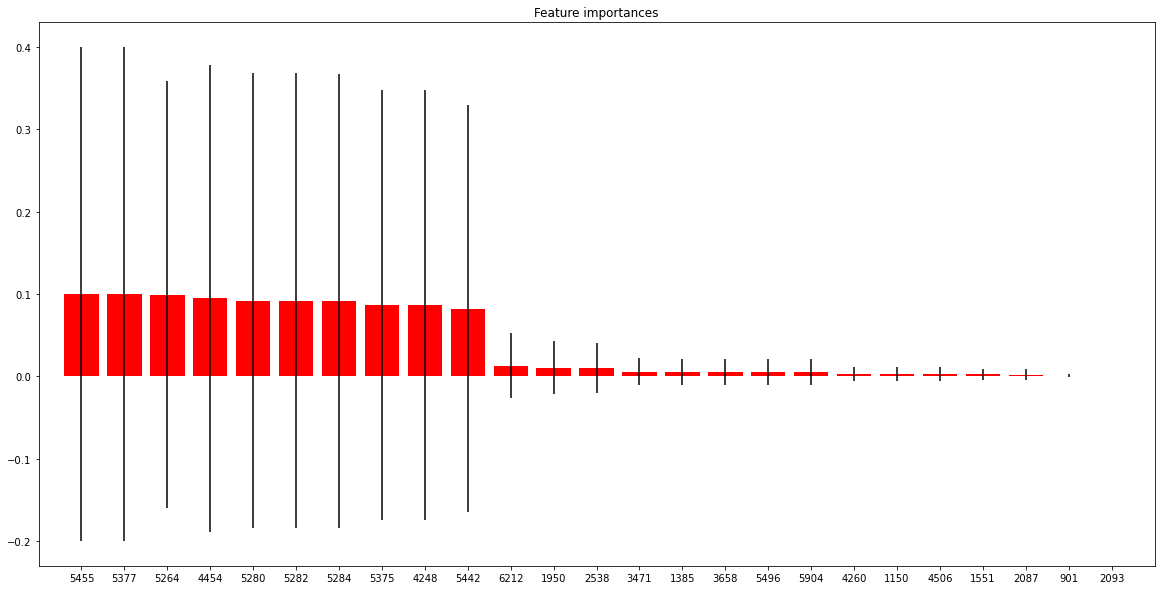

In [44]:
def main():    
    
    today = date.today()
    
    #for method in ["dlib"]: #, "deepface"]:

    #results_file = open("results/results_dlib-deepface_" + str(today)+".txt", "w")

    age_ranges = [[1, 40]] # [[1, 3], [4, 16], [17, 40], [1, 40]] 

    for [lowest_age, highest_age] in age_ranges:

        method = "dlib"

        kdv_csv = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\representations\kdv-patients-"+method+"-cropped-age-group-"+str(lowest_age)+"-"+str(highest_age)+".csv"    
        ID_csv  = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\representations\ID-controls-"+method+"-cropped-age-group-"+str(lowest_age)+"-"+str(highest_age)+".csv"

        data_dlib, labels_dlib = read_dlib_rep(kdv_csv, ID_csv)

        method = "deepface"

        kdv_csv = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\representations\kdv-patients-"+method+"-cropped-age-group-"+str(lowest_age)+"-"+str(highest_age)+".csv"    
        ID_csv  = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\representations\ID-controls-"+method+"-cropped-age-group-"+str(lowest_age)+"-"+str(highest_age)+".csv"

        data_df, labels_df = read_deepface_rep(kdv_csv, ID_csv)
        #data, labels = read_deepface_rep(kdv_csv, ID_csv)
        
        # CHECK METHOD
        #if method == "dlib":
        #data_df, labels_df = read_deepface_rep(kdv_csv, ID_csv)
        #if method =="deepface":

        nr_components, data, labels = concatenate(data_df, labels_df, data_dlib, labels_dlib)

        # plot representation
        #plot_pca_tsne(data, labels, lowest_age, highest_age)

        # write results and also the parameters to a file 
        # print("Best accuracies to classify the age group " + str(lowest_age) + "-" + str(highest_age))
        # results_file.write("Classifier results for kdv-control age group " + str(lowest_age) + "-" + str(highest_age) + "\n")
        #results_file.write("Nr of pca components used: {}".format(nr_components))
       
        # apply classifiers
        # print("K-NN classifier:")
        #k, knn_norm, knn_aroc, knn_spec, knn_sens = knn_classifier(data, labels)
        #results_file.write("knn classifier (k = {}), normalize : {} \nspecificity: {}, sensitivity: {}, AROC: {} \n".format(k, knn_norm, knn_spec, knn_sens, knn_aroc))

        # print("SVM classifier:")
        #kernel, svm_norm, svm_aroc, svm_spec, svm_sens = svm_classifier(data, labels)
        #results_file.write("svm classifier (k = {}), normalize : {} \nspecificity: {}, sensitivity: {}, AROC: {} \n".format(kernel, svm_norm, svm_spec, svm_sens, svm_aroc))

        # print("Random Forest classifier:")
        n_trees_rf, rf_norm, rf_aroc, rf_spec, rf_sens = rf_classifier(data, labels)
        results_file.write("Random Forest classifier (trees = {}), normalize : {} \nspecificity: {}, sensitivity: {}, AROC: {} \n".format(n_trees_rf, rf_norm, rf_spec, rf_sens, rf_aroc))
        
        break
        
        # print("Gradient Boost classifier:")
        n_trees_gr, gr_norm, gr_aroc, gr_spec, gr_sens = gr_classifier(data, labels)
        results_file.write("Gradient Boost classifier (trees = {}), normalize : {} \nspecificity: {}, sensitivity: {}, AROC: {} \n".format(n_trees_gr, gr_norm, gr_spec, gr_sens, gr_aroc))

        # print("Ada Boost classifier:")
        n_trees_ada, ada_norm, ada_aroc, ada_spec, ada_sens = ada_classifier(data, labels)
        results_file.write("Ada Boost classifier (trees = {}), normalize : {} \nspecificity: {}, sensitivity: {}, AROC: {} \n".format(n_trees_ada, ada_norm, ada_spec, ada_sens, ada_aroc))

#         ensemble_acc, clf_combination, best_vote, ensemble_norm = ensemble_classifiers(k, kernel, n_trees_rf, n_trees_gr, n_trees_ada, data, labels) 
#         print("ensemble classifier has acc: {:.3f} \n with ensemble: {}".format(ensemble_acc, str(clf_combination)))
#         print("\n \n \n")

#         results_file.write("ensemble classifier with acc: " + str(ensemble_acc) + " with the combination " + str(clf_combination) + " and best vote " + str(best_vote) + " and normalize = " + str(ensemble_norm) + "\n")
#         results_file.write("\n \n ")  

        results_file.write("\n")

    results_file.close()
    print("done running main file")
        
main()
    

### Method 7: VotingClassifier with GridSearch

https://www.kaggle.com/rmferg/soft-voting-classifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

import time
t0 = time.clock()

tree = DecisionTreeClassifier(random_state=1)
svm = SVC(probability=True, kernel='rbf')
knn = KNeighborsClassifier(p=2, metric='minkowski')
nb = GaussianNB()
eclf = VotingClassifier(estimators=[('tree', tree), ('svm', svm), ('knn', knn),('nb', nb)], voting='soft')

param_range10 = [.001, .01, 1, 10, 100]
param_range1 = list(range(3, 8))
param_grid = [{'svm__C':param_range10, 'svm__gamma':param_range10, 'tree__max_depth':param_range1, 
               'knn__n_neighbors':param_range1}]

gs = GridSearchCV(estimator=eclf, param_grid=param_grid, scoring='accuracy', cv=5)
gs = gs.fit(X_train_std, y_train)

print('Best accuracy score: %.3f \nBest parameters: %s' % (gs.best_score_, gs.best_params_))

clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
t1 = time.clock()
print('Running time: %.3f' % (t1-t0))

from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_std)
print('ROC AUC: %.3f \nAccuracy: %.3f \nConfusion Matrix:' % (roc_auc_score(y_true=y_test, y_score=y_pred),
                                         accuracy_score(y_true=y_test, y_pred=y_pred)))
print(confusion_matrix(y_true=y_test, y_pred=y_pred))